## QK sparsity

In the SCFA paper, QK sparsity is used as a proof of concept where we randomly drop some of the QK indices.

In [1]:
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load
import os

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.6" # for our RTX 3090. Modify for your own GPU.
os.environ["MAX_JOBS"] = "16" # use some of Bentham's many cores
hash_attn_kernel = load(
    name="hash_attn", sources=[os.path.normpath(os.path.join(os.getcwd(), "../source/splashattn/splash_main.cpp")), 
                                  os.path.normpath(os.path.join(os.getcwd(), "../source/splashattn/splash.cu"))], 
                                  extra_cuda_cflags=["-O2"],
)

In [2]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
def reference_qk_sparse_attn(q, k, v, sm_scale: float = 1.0, indices_to_keep: torch.Tensor = None, keep_prob: float = 0.2):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if indices_to_keep is None:
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
    q_slice = q[..., indices_to_keep, :]
    k_slice = k[..., indices_to_keep, :]
    v_slice = v[..., indices_to_keep, :]
    n_slice = len(indices_to_keep)
    attn_scores = torch.matmul(q_slice, k_slice.transpose(-2, -1)) * sm_scale
    attn_mask = torch.ones(B, H, n_slice, n_slice, device = q.device, dtype = torch.bool)
    attn_mask = torch.tril(attn_mask, diagonal = 0)
    attn_scores = attn_scores.masked_fill(~attn_mask, float("-inf"))
    attn = F.softmax(attn_scores, dim=-1)
    # sns.heatmap(attn.cpu().numpy().squeeze(), annot = False, cmap = "viridis")
    # plt.show()
    # return
    attn = attn.nan_to_num(0.0) # some cols will be totally masked out and softmax will produce NaNs
    slice_out = torch.matmul(attn, v_slice)
    out = torch.zeros_like(q)
    out[..., indices_to_keep, :] = slice_out
    return out


q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
reference_qk_sparse_attn(q, k, v)

tensor([[[[ 1.3024,  0.5811, -0.2668,  ...,  2.0730,  0.1460, -0.5225],
          [ 1.3017,  0.5792, -0.2675,  ...,  2.0685,  0.1457, -0.5219],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.1811,  0.9874,  0.5244,  ...,  0.3581,  0.0257, -0.1703],
          [ 0.1101,  1.1278, -0.2450,  ...,  0.3789,  0.1643, -0.5654],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]],
       device='cuda:0')

### Our QK Sparse kernel:

In [3]:
def kernel_qk_sparse_attn(q, k, v, sm_scale: float = 1.0, indices_to_keep: torch.Tensor = None, keep_prob: float = 0.2):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if indices_to_keep is None:
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
    out = torch.zeros_like(q)
    q = q[..., indices_to_keep, :]
    k = k[..., indices_to_keep, :]
    v = v[..., indices_to_keep, :]
    Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
    Q_idx = Q_idx.expand(B, H, N)[..., indices_to_keep].contiguous().int()
    K_idx = torch.arange(N, device=q.device).view(1, 1, N)
    K_idx = K_idx.expand(B, H, N)[..., indices_to_keep].contiguous().int()
    kernel_output = hash_attn_kernel.forward(q, k, v, Q_idx, K_idx, sm_scale)
    # print(out[..., indices_to_keep, :].shape, kernel_output.shape)
    out[..., indices_to_keep, :] = kernel_output
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
kernel_qk_sparse_attn(q, k, v)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 2.7692, -1.5084,  0.8888,  ...,  1.0758, -0.5363,  0.2249],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]],
       device='cuda:0')

### Correctness check:

Mean absolute error:  tensor(9.8614e-09, device='cuda:0')


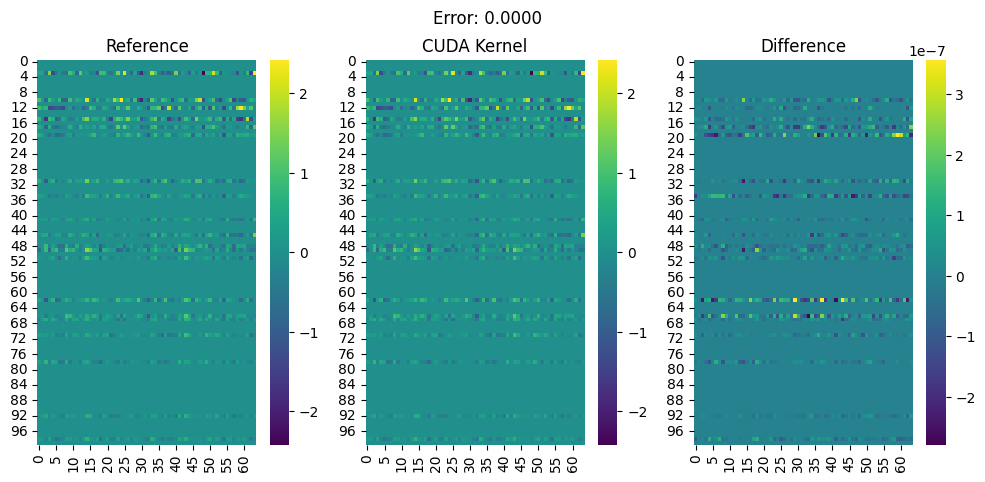

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
B = 1
H = 1
N = 100
D = 64
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
reference_output = reference_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)

mae = (reference_output - kernel_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy() - reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("CUDA Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"Error: {mae:.4f}")
plt.show()


### SCFA's Reference Implementation:

Mean absolute error:  tensor(7.1998e-05, device='cuda:0')


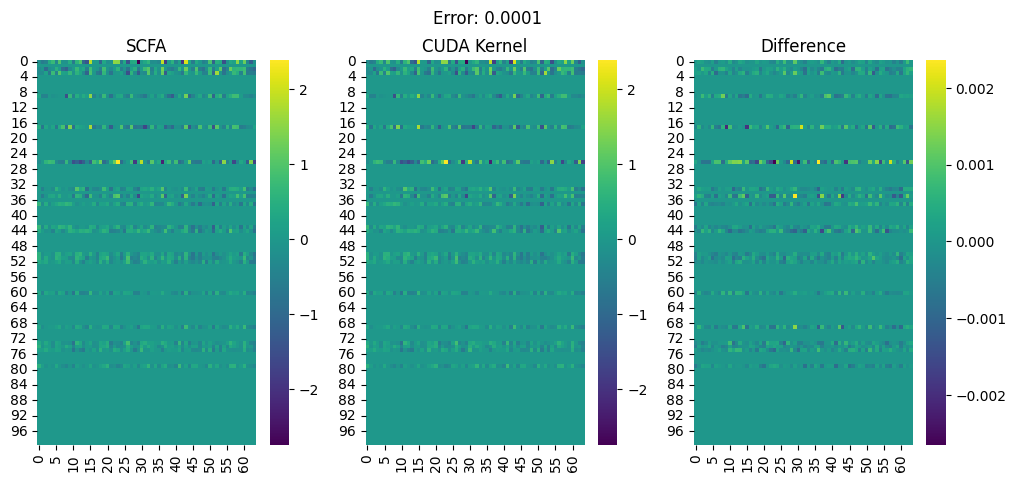

In [5]:
from source.scfa_paper.scfa_wrapper import qk_sparse_attention
import seaborn as sns
from matplotlib import pyplot as plt
B = 1
H = 1
N = 100
D = 64
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)

def prep_scfa_input(q, k, v, indices_to_keep):
    # Prepare input for SCFA kernel
    B, H, N, D = q.shape
    binary_mask = torch.zeros(B, H, N, device = "cuda", dtype=torch.float32)
    binary_mask[:, :, indices_to_keep] = 1.0
    binary_mask = binary_mask.transpose(1, 2).contiguous() # (B, N, H) -> as SCFA expects
    scfa_q = q.clone().transpose(1, 2).contiguous() # (B, N, H, D) -> as SCFA expects
    scfa_k = k.clone().transpose(1, 2).contiguous()
    scfa_v = v.clone().transpose(1, 2).contiguous()

    return scfa_q, scfa_k, scfa_v, binary_mask

def prep_scfa_output(scfa_output):
    return scfa_output.transpose(1, 2)

scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
scfa_output = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
scfa_output = prep_scfa_output(scfa_output)

mae = (kernel_output - scfa_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(scfa_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(scfa_output.squeeze().cpu().numpy() - kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("SCFA")
axes[1].set_title("CUDA Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"Error: {mae:.4f}")
plt.show()


### Sanity Check (this should pass):

In [6]:
B = 1
H = 1
N = 100
D = 64
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
reference_output = reference_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
scfa_output = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
scfa_output = prep_scfa_output(scfa_output)

print("Paper <> Reference Max Error: ", (scfa_output - reference_output).abs().max())
print("Reference <> CUDA Max Error: ", (reference_output - kernel_output).abs().max())
print("Paper <> CUDA Max Error: ", (kernel_output - scfa_output).abs().max())

assert (kernel_output - scfa_output).abs().max() < 5e-3, "SCFA and CUDA kernel outputs should match"
assert (kernel_output - reference_output).abs().max() < 5e-3, "CUDA kernel and reference outputs should match"
assert (scfa_output - reference_output).abs().max() < 5e-3, "SCFA and reference outputs should match"

Paper <> Reference Max Error:  tensor(0.0029, device='cuda:0')
Reference <> CUDA Max Error:  tensor(5.9605e-07, device='cuda:0')
Paper <> CUDA Max Error:  tensor(0.0029, device='cuda:0')


In [7]:
scfa_q.shape, scfa_k.shape, scfa_v.shape, binary_mask.shape

(torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1]))

### Speed Comparison:

Benchmarking sequence length: 256
  Standard: 0.0001s
  Reference QK: 0.0003s
  Kernel QK: 0.0003s
  SCFA QK: 0.0012s
Benchmarking sequence length: 512
  Standard: 0.0001s
  Reference QK: 0.0002s
  Kernel QK: 0.0004s
  SCFA QK: 0.0011s
Benchmarking sequence length: 1024
  Standard: 0.0003s
  Reference QK: 0.0002s
  Kernel QK: 0.0006s
  SCFA QK: 0.0006s
Benchmarking sequence length: 2048
  Standard: 0.0008s
  Reference QK: 0.0003s
  Kernel QK: 0.0011s
  SCFA QK: 0.0006s
Benchmarking sequence length: 4096
  Standard: 0.0026s
  Reference QK: 0.0006s
  Kernel QK: 0.0023s
  SCFA QK: 0.0008s
Benchmarking sequence length: 8192
  Standard: 0.0087s
  Reference QK: 0.0023s
  Kernel QK: 0.0065s
  SCFA QK: 0.0024s
Benchmarking sequence length: 16384
  Standard: 0.0354s
  Reference QK: 0.0072s
  Kernel QK: 0.0197s
  SCFA QK: 0.0021s
Benchmarking sequence length: 32768
  Standard: 0.1495s
  Reference QK: 0.0299s
  Kernel QK: 0.0732s
  SCFA QK: 0.0051s


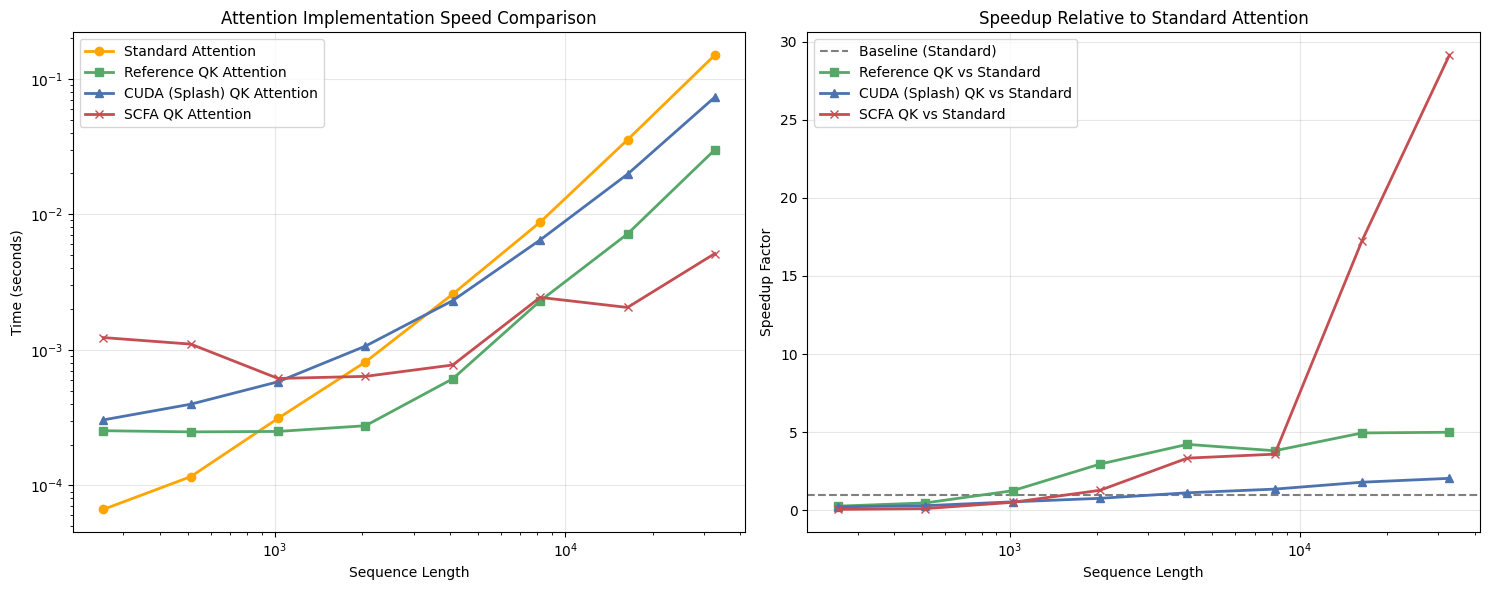


Benchmark Summary:
Seq Len    Standard (s)    Reference (s)   Kernel (s)      Ref Speedup  Kernel Speedup  SCFA (s)        SCFA Speedup   
--------------------------------------------------------------------------------
256        0.0001          0.0003          0.0003          0.26        x 0.22           x 0.0012          0.05           x
512        0.0001          0.0002          0.0004          0.47        x 0.29           x 0.0011          0.11           x
1024       0.0003          0.0002          0.0006          1.25        x 0.54           x 0.0006          0.51           x
2048       0.0008          0.0003          0.0011          2.96        x 0.76           x 0.0006          1.28           x
4096       0.0026          0.0006          0.0023          4.22        x 1.12           x 0.0008          3.34           x
8192       0.0087          0.0023          0.0065          3.81        x 1.35           x 0.0024          3.59           x
16384      0.0354          0.0072        

In [8]:
import time
import torch.nn.functional as F

# Benchmark code courtesy of Claude 4.0
def benchmark_attention_methods(seq_lens, d_model=64, num_heads=8, num_buckets=16, num_trials=10):
    """Benchmark different attention implementations across various sequence lengths."""
    results = {
        'seq_lens': [],
        'standard_attention': [],
        'reference_qk_attention': [],
        'kernel_qk_attention': [],
        'scfa_qk_attention': []
    }
    
    for seq_len in seq_lens:
        print(f"Benchmarking sequence length: {seq_len}")
        
        # Generate test data
        B, H, N, D = 1, num_heads, seq_len, d_model
        q = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        k = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        v = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
        
        # Warm up GPU
        for _ in range(3):
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            _ = reference_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            _ = kernel_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
        
        torch.cuda.synchronize()
        
        # Benchmark standard attention
        times_standard = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            torch.cuda.synchronize()
            times_standard.append(time.time() - start_time)
        
        # Benchmark reference qk attention
        times_reference = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = reference_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            torch.cuda.synchronize()
            times_reference.append(time.time() - start_time)
        
        # Benchmark kernel qk attention
        times_kernel = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = kernel_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            torch.cuda.synchronize()
            times_kernel.append(time.time() - start_time)

        # Benchmark SCFA Triton qk attention
        times_scfa = []
        for _ in range(num_trials):
            scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
            start_time = time.time()
            _ = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
            torch.cuda.synchronize()
            times_scfa.append(time.time() - start_time)
        
        # Store results (average times)
        results['seq_lens'].append(seq_len)
        results['standard_attention'].append(sum(times_standard) / len(times_standard))
        results['reference_qk_attention'].append(sum(times_reference) / len(times_reference))
        results['kernel_qk_attention'].append(sum(times_kernel) / len(times_kernel))
        results['scfa_qk_attention'].append(sum(times_scfa) / len(times_scfa))

        print(f"  Standard: {results['standard_attention'][-1]:.4f}s")
        print(f"  Reference QK: {results['reference_qk_attention'][-1]:.4f}s")
        print(f"  Kernel QK: {results['kernel_qk_attention'][-1]:.4f}s")
        print(f"  SCFA QK: {results['scfa_qk_attention'][-1]:.4f}s")
    return results

# Run benchmark
seq_lengths = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
benchmark_results = benchmark_attention_methods(seq_lengths)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Absolute times
ax1.plot(benchmark_results['seq_lens'], benchmark_results['standard_attention'], 'o-', label='Standard Attention', linewidth=2, color = "orange")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['reference_qk_attention'], 's-', label='Reference QK Attention', linewidth=2, color = "#55A868")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['kernel_qk_attention'], '^-', label='CUDA (Splash) QK Attention', linewidth=2, color = "#4C72B0")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['scfa_qk_attention'], 'x-', label='SCFA QK Attention', linewidth=2, color = "#C44E52")
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Attention Implementation Speed Comparison')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup relative to standard attention
standard_times = benchmark_results['standard_attention']
reference_speedup = [std/ref for std, ref in zip(standard_times, benchmark_results['reference_qk_attention'])]
kernel_speedup = [std/ker for std, ker in zip(standard_times, benchmark_results['kernel_qk_attention'])]
scfa_speedup = [std/scfa for std, scfa in zip(standard_times, benchmark_results['scfa_qk_attention'])]

ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline (Standard)')
ax2.plot(benchmark_results['seq_lens'], reference_speedup, 's-', label='Reference QK vs Standard', linewidth=2, color = "#55A868")
ax2.plot(benchmark_results['seq_lens'], kernel_speedup, '^-', label='CUDA (Splash) QK vs Standard', linewidth=2, color = "#4C72B0")
ax2.plot(benchmark_results['seq_lens'], scfa_speedup, 'x-', label='SCFA QK vs Standard', linewidth=2, color = "#C44E52")
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Relative to Standard Attention')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nBenchmark Summary:")
print("=" * 80)
print(f"{'Seq Len':<10} {'Standard (s)':<15} {'Reference (s)':<15} {'Kernel (s)':<15} {'Ref Speedup':<12} {'Kernel Speedup':<15} {'SCFA (s)':<15} {'SCFA Speedup':<15}")
print("-" * 80)
for i, seq_len in enumerate(benchmark_results['seq_lens']):
    std_time = benchmark_results['standard_attention'][i]
    ref_time = benchmark_results['reference_qk_attention'][i]
    ker_time = benchmark_results['kernel_qk_attention'][i]
    scfa_time = benchmark_results['scfa_qk_attention'][i]
    ref_speedup = std_time / ref_time
    ker_speedup = std_time / ker_time
    scfa_speedup = std_time / scfa_time
    print(f"{seq_len:<10} {std_time:<15.4f} {ref_time:<15.4f} {ker_time:<15.4f} {ref_speedup:<12.2f}x {ker_speedup:<15.2f}x {scfa_time:<15.4f} {scfa_speedup:<15.2f}x")


## Locality-Sensitive Hashing
See mechanism described in the Reformer paper: https://arxiv.org/pdf/2001.04451

We hash $Q$ and $K$ into $B$ buckets by using a random matrix $R \in \mathbb{R}^{d \times b/2}$ and taking $\argmax([xR; −xR])$. As per the Johnson-Lindenstrauss lemma, this maps $Q$ and $K$ into a $b/2$-dimensional space in a relative-distance preserving way.

In [8]:
def vector_hash_fn(x: torch.Tensor, num_buckets: int, R: torch.Tensor) -> torch.Tensor:
    """
    x: (..., D)
    R: (D, b/2)
    """
    D = x.shape[-1]
    assert R.shape == (D, num_buckets // 2)
    return torch.argmax(torch.cat([x @ R, -x @ R], dim=-1), dim=-1)

def get_vector_hash(D: int, num_buckets: int, device: torch.device = "cpu", dtype: torch.dtype = torch.bfloat16) -> torch.Tensor:
    R = torch.randn(D, num_buckets // 2, device = device, dtype = dtype)
    return lambda x: vector_hash_fn(x, num_buckets, R)

vector_hash = get_vector_hash(D = 10, num_buckets = 10)
vector_hash(torch.randn(50, 10, dtype = torch.bfloat16))

tensor([0, 8, 0, 5, 3, 8, 2, 3, 1, 8, 3, 6, 0, 8, 9, 8, 8, 1, 7, 1, 6, 6, 1, 1,
        8, 5, 7, 5, 8, 7, 6, 7, 7, 2, 6, 6, 8, 8, 8, 9, 9, 4, 6, 6, 1, 3, 0, 3,
        3, 9])

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
def reference_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)

    Note: This implementation sucks! It's just a sanity check.
    """
    assert num_buckets % 2 == 0, "num_buckets must be even"
    if vector_hash is None:
        vector_hash = get_vector_hash(D = q.shape[-1], num_buckets = num_buckets, device = q.device)
    B, H, N, D = q.shape
    q_hashes = vector_hash(q) # (B, H, N)
    k_hashes = vector_hash(k) # (B, H, N)
    out = torch.zeros_like(q)
    for i in range(num_buckets):
        for b in range(B):
            for h in range(H):
                q_mask = (q_hashes[b][h] == i) # (N)
                k_mask = (k_hashes[b][h] == i) # (N)
                q_indices = torch.nonzero(q_mask, as_tuple=False).squeeze() # (N)
                k_indices = torch.nonzero(k_mask, as_tuple=False).squeeze() # (N)
                if q_indices.numel() == 0 or k_indices.numel() == 0:
                    continue
                q_bucket = q[b, h, q_indices] # (N, D)
                k_bucket = k[b, h, k_indices] # (N, D)
                v_bucket = v[b, h, k_indices] # (N, D)
                attn_mask = q_indices.unsqueeze(-1) >= k_indices.unsqueeze(-2)
                attn_scores = torch.matmul(q_bucket, k_bucket.transpose(-2, -1)) * sm_scale
                attn_scores = attn_scores.masked_fill(~attn_mask, float("-inf"))
                attn = F.softmax(attn_scores, dim=-1)
                attn = attn.nan_to_num(0.0) # some cols will be totally masked out and softmax will produce NaNs
                # sns.heatmap(attn.cpu().numpy().squeeze(), annot = False, mask = ~attn_mask.cpu().numpy().squeeze())
                # plt.show()
                # return
                partial_prod = torch.matmul(attn, v_bucket)
                out[b, h, q_indices] += partial_prod
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.bfloat16)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.bfloat16)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.bfloat16)
reference_hash_attn(q, k, v, num_buckets=4)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.8398,  1.0312,  1.4219,  ...,  0.5430, -0.8438, -0.3711],
          ...,
          [-0.7188,  0.6211,  0.0903,  ...,  0.0137,  0.5938, -1.5938],
          [ 1.3750,  0.6523, -0.2852,  ..., -0.5469,  0.4961, -0.5938],
          [-0.2461,  1.9609,  0.1943,  ..., -1.6484,  0.4980,  0.0708]]]],
       device='cuda:0', dtype=torch.bfloat16)

## Comparison with our CUDA kernel:

In [10]:
def kernel_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    assert num_buckets % 2 == 0, "num_buckets must be even"
    if vector_hash is None:
        vector_hash = get_vector_hash(D = q.shape[-1], num_buckets = num_buckets, device = q.device)
    B, H, N, D = q.shape
    q_hashes = vector_hash(q) # (B, H, N)
    k_hashes = vector_hash(k) # (B, H, N)
    Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
    Q_idx = Q_idx.expand(B, H, N).contiguous().int()
    K_idx = torch.arange(N, device=q.device).view(1, 1, N)
    K_idx = K_idx.expand(B, H, N).contiguous().int()
    max_q_size, max_k_size = 0, 0
    out = torch.zeros_like(q)
    for i in range(num_buckets):
        for b in range(B):
            for h in range(H):
                num_q = (q_hashes[b][h] == i).sum() # (N)
                num_k = (k_hashes[b][h] == i).sum() # (N)
                max_q_size = max(max_q_size, num_q)
                max_k_size = max(max_k_size, num_k)
        q_tensor = torch.zeros(B, H, max_q_size, D, device = q.device, dtype=torch.float32)
        k_tensor = torch.zeros(B, H, max_k_size, D, device = q.device, dtype=torch.float32)
        v_tensor = torch.zeros(B, H, max_k_size, D, device = q.device, dtype=torch.float32)
        q_idx_tensor = torch.zeros(B, H, max_q_size, device = q.device, dtype=torch.int32)
        k_idx_tensor = torch.zeros(B, H, max_k_size, device = q.device, dtype=torch.int32)
        pad_mask_q = torch.zeros(B, H, max_q_size, device = q.device, dtype=torch.bool)
        for b in range(B):
            for h in range(H):
                q_mask = (q_hashes[b][h] == i)
                k_mask = (k_hashes[b][h] == i)
                num_q = q_mask.sum()
                num_k = k_mask.sum()
                q_tensor[b, h, :num_q] = q[b, h, q_mask]
                k_tensor[b, h, :num_k] = k[b, h, k_mask]
                v_tensor[b, h, :num_k] = v[b, h, k_mask]
                q_idx_tensor[b, h, :num_q] = Q_idx[b, h, q_mask]
                k_idx_tensor[b, h, :num_k] = K_idx[b, h, k_mask]
                pad_mask_q[b, h, :num_q] = True

        # Note that, at this point, q_idx_tensor and k_idx_tensor should already be sorted due to their initialization with arange
        q_tensor, q_idx_tensor, k_tensor, k_idx_tensor = q_tensor.contiguous(), q_idx_tensor.contiguous(), k_tensor.contiguous(), k_idx_tensor.contiguous()
        kernel_out = hash_attn_kernel.forward(q_tensor, k_tensor, v_tensor, q_idx_tensor, k_idx_tensor, sm_scale)
        kernel_out = kernel_out.masked_fill(~pad_mask_q.unsqueeze(-1), 0.0)
        # print(kernel_out.shape, max_q_size, max_k_size, q_idx_tensor.shape, k_idx_tensor.shape, q_tensor.shape, k_tensor.shape)
        # print(q_idx_tensor)
        batch_idx = torch.arange(B).view(B, 1, 1).expand(B, H, max_q_size)
        head_idx = torch.arange(H).view(1, H, 1).expand(B, H, max_q_size)
        out[batch_idx, head_idx, q_idx_tensor] += kernel_out
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.bfloat16)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.bfloat16)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.bfloat16)
kernel_hash_attn(q, k, v, num_buckets=4)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.2500,  0.5469, -2.2031,  ..., -0.3105,  1.2344, -0.9961],
          [ 0.7617, -0.0947,  1.0156,  ...,  0.4941, -0.7773, -2.0156],
          [ 1.0078, -0.7969, -1.2734,  ...,  0.4141, -0.1904, -1.0469]]]],
       device='cuda:0', dtype=torch.bfloat16)

### Correctness check:

Mean absolute error:  tensor(0.0271, device='cuda:0', dtype=torch.bfloat16)


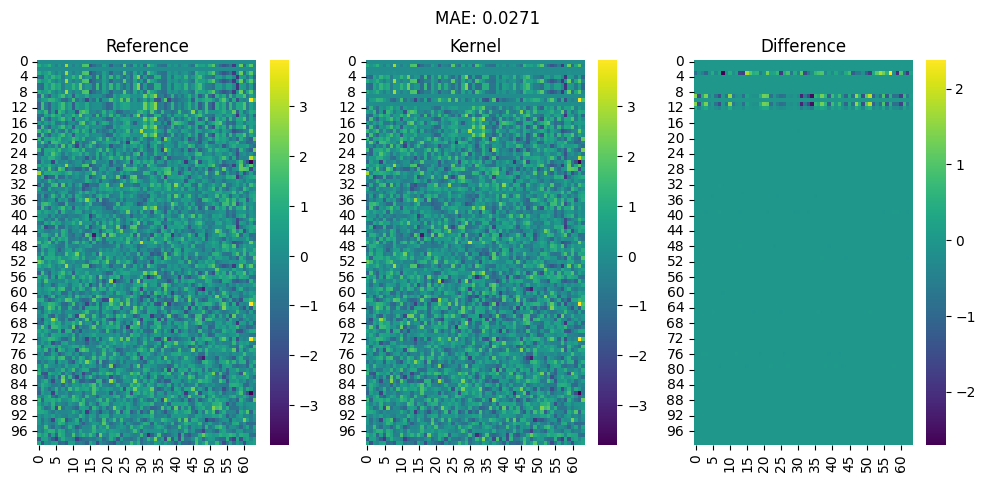

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
D = 64
q = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.bfloat16)
k = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.bfloat16)
v = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.bfloat16)
standard_vector_hash = get_vector_hash(D = D, num_buckets = 4, device = "cuda")
reference_output =reference_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)
kernel_output = kernel_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)

mae = (reference_output - kernel_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
vis_reference = reference_output.squeeze().to(torch.float32).cpu().numpy()
vis_kernel = kernel_output.squeeze().to(torch.float32).cpu().numpy()
sns.heatmap(vis_reference, annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(vis_kernel, annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(vis_kernel - vis_reference, annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"MAE: {mae:.4f}")
plt.show()


### SCFA's Reference Hash Attention:

Mean absolute error:  tensor(0.0017, device='cuda:0', dtype=torch.bfloat16)


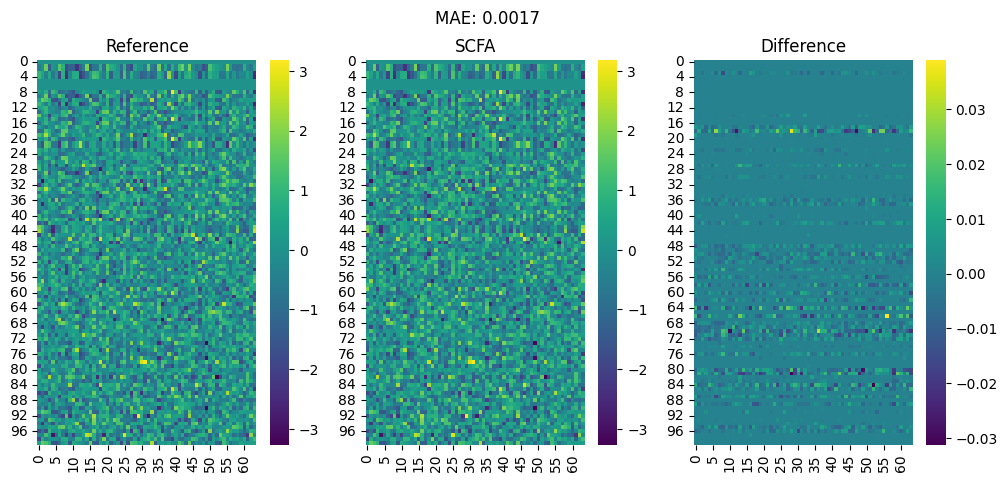

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
from source.scfa_paper.scfa_wrapper import hash_sparse_attention

D = 64
def scfa_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if vector_hash is None:
        vector_hash = get_vector_hash(D = D, num_buckets = num_buckets, device = q.device)
    q_hashes = vector_hash(q).to(torch.int32).transpose(1, 2).contiguous() # (B, N, H)
    k_hashes = vector_hash(k).to(torch.int32).transpose(1, 2).contiguous() # (B, N, H)
    scfa_q = q.transpose(1, 2).contiguous() # (B, N, H, D)
    scfa_k = k.transpose(1, 2).contiguous() # (B, N, H, D)
    scfa_v = v.transpose(1, 2).contiguous() # (B, N, H, D)
    return hash_sparse_attention(scfa_q, scfa_k, scfa_v, q_hashes, k_hashes, sm_scale).transpose(1, 2).contiguous()

q = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.bfloat16)
v = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.bfloat16)
standard_vector_hash = get_vector_hash(D = D, num_buckets = 4, device = "cuda")
reference_output =reference_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)
scfa_output = scfa_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)

mae = (reference_output - scfa_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
vis_reference = reference_output.squeeze().to(torch.float32).cpu().numpy()
vis_scfa = scfa_output.squeeze().to(torch.float32).cpu().numpy()
sns.heatmap(vis_reference, annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(vis_scfa, annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(vis_scfa - vis_reference, annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("SCFA")
axes[2].set_title("Difference")
plt.suptitle(f"MAE: {mae:.4f}")
plt.show()


### V2 Hash Sparse Attention:

In [13]:
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load
import os

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.6" # for our RTX 3090. Modify for your own GPU.
os.environ["MAX_JOBS"] = "16" # use some of Bentham's many cores
v2_hash_sparse_attn_kernel = load(
    name="v2_hash_sparse_attn", sources=[os.path.normpath(os.path.join(os.getcwd(), "../source/v2/hash_sparse_forward.cu"))], 
                                  extra_cuda_cflags=["-O2"],
)

Mean absolute error:  tensor(0.0054, device='cuda:0')


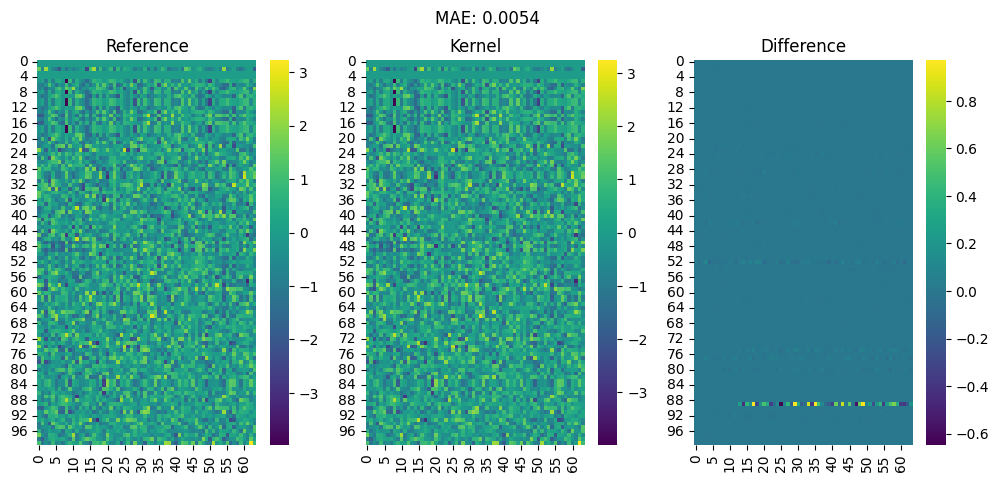

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
D = 64
q = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.bfloat16)
k = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.bfloat16)
v = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.bfloat16)

def v2_hash_sparse_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if vector_hash is None:
        vector_hash = get_vector_hash(D = D, num_buckets = num_buckets, device = q.device)
    q_hashes = vector_hash(q).to(torch.int32).contiguous() # (B, N, H)
    k_hashes = vector_hash(k).to(torch.int32).contiguous() # (B, N, H)
    Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
    Q_idx = Q_idx.expand(B, H, N).contiguous().to(torch.int32)
    K_idx = torch.arange(N, device=q.device).view(1, 1, N)
    K_idx = K_idx.expand(B, H, N).contiguous().to(torch.int32)
    return v2_hash_sparse_attn_kernel.forward(q.to(torch.bfloat16), 
                                              k.to(torch.bfloat16), 
                                              v.to(torch.bfloat16), 
                                              Q_idx, 
                                              K_idx, 
                                              q_hashes, 
                                              k_hashes, 
                                              sm_scale).to(torch.float32).nan_to_num(0.0)

standard_vector_hash = get_vector_hash(D = D, num_buckets = 4, device = "cuda")
reference_output =reference_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)
v2_output = v2_hash_sparse_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)

mae = (reference_output - v2_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
vis_reference = reference_output.squeeze().to(torch.float32).cpu().numpy()
vis_v2 = v2_output.squeeze().to(torch.float32).cpu().numpy()
sns.heatmap(vis_reference, annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(vis_v2, annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(vis_v2 - vis_reference, annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"MAE: {mae:.4f}")
plt.show()


## Speed comparison:

In [ ]:
import time
import torch.nn.functional as F

# Benchmark code courtesy of Claude 4.0
def benchmark_attention_methods(seq_lens, d_model=64, num_heads=8, num_buckets=16, num_trials=10):
    """Benchmark different attention implementations across various sequence lengths."""
    results = {
        'seq_lens': [],
        'standard_attention': [],
        'reference_hash_attention': [],
        'kernel_hash_attention': [],
        'v2_hash_attention': [],
        'scfa_hash_attention': []
    }
    
    for seq_len in seq_lens:
        print(f"Benchmarking sequence length: {seq_len}")
        
        # Generate test data
        B, H, N, D = 1, num_heads, seq_len, d_model
        q = torch.randn(B, H, N, D, device="cuda", dtype=torch.bfloat16)
        k = torch.randn(B, H, N, D, device="cuda", dtype=torch.bfloat16)
        v = torch.randn(B, H, N, D, device="cuda", dtype=torch.bfloat16)
        
        # Create shared vector hash for fair comparison
        standard_vector_hash = get_vector_hash(D=D, num_buckets=num_buckets, device="cuda", dtype=torch.bfloat16)
        
        # Warm up GPU
        for _ in range(3):
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            _ = reference_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            _ = kernel_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
        
        torch.cuda.synchronize()
        
        # Benchmark standard attention
        times_standard = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            torch.cuda.synchronize()
            times_standard.append(time.time() - start_time)
        
        # Benchmark reference hash attention
        times_reference = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = reference_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            torch.cuda.synchronize()
            times_reference.append(time.time() - start_time)
        
        # Benchmark kernel hash attention
        times_kernel = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = kernel_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            torch.cuda.synchronize()
            times_kernel.append(time.time() - start_time)

        # Benchmark v2 hash attention
        # times_v2 = []
        # for _ in range(num_trials):
        #     start_time = time.time()
        #     _ = v2_hash_sparse_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
        #     torch.cuda.synchronize()
        #     times_v2.append(time.time() - start_time)

        # Benchmark SCFA hash attention
        times_scfa = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = scfa_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            torch.cuda.synchronize()
            times_scfa.append(time.time() - start_time)
        
        # Store results (average times)
        results['seq_lens'].append(seq_len)
        results['standard_attention'].append(sum(times_standard) / len(times_standard))
        results['reference_hash_attention'].append(sum(times_reference) / len(times_reference))
        results['kernel_hash_attention'].append(sum(times_kernel) / len(times_kernel))
        # results['v2_hash_attention'].append(sum(times_v2) / len(times_v2))
        results['scfa_hash_attention'].append(sum(times_scfa) / len(times_scfa))

        print(f"  Standard: {results['standard_attention'][-1]:.4f}s")
        print(f"  Reference Hash: {results['reference_hash_attention'][-1]:.4f}s")
        print(f"  Kernel Hash: {results['kernel_hash_attention'][-1]:.4f}s")
        print(f"  SCFA Hash: {results['scfa_hash_attention'][-1]:.4f}s")
        # print(f"  V2 Hash: {results['v2_hash_attention'][-1]:.4f}s")
    return results

# Run benchmark
seq_lengths = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
benchmark_results = benchmark_attention_methods(seq_lengths)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Absolute times
ax1.plot(benchmark_results['seq_lens'], benchmark_results['standard_attention'], 'o-', label='Standard Attention', linewidth=2, color = "#55A868")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['reference_hash_attention'], 's-', label='Reference Hash Attention', linewidth=2, color = "#4C72B0")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['kernel_hash_attention'], '^-', label='CUDA (Splash) Hash Attention', linewidth=2, color = "#C44E52")
# ax1.plot(benchmark_results['seq_lens'], benchmark_results['v2_hash_attention'], 'd-', label='CUDA (V2) Hash Attention', linewidth=2, color = "#55A868")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['scfa_hash_attention'], 'x-', label='Triton (SCFA) Hash Attention', linewidth=2, color = "#8172B2")
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Attention Implementation Speed Comparison')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup relative to standard attention
standard_times = benchmark_results['standard_attention']
reference_speedup = [std/ref for std, ref in zip(standard_times, benchmark_results['reference_hash_attention'])]
kernel_speedup = [std/ker for std, ker in zip(standard_times, benchmark_results['kernel_hash_attention'])]
v2_speedup = [std/v2 for std, v2 in zip(standard_times, benchmark_results['v2_hash_attention'])]
scfa_speedup = [std/scfa for std, scfa in zip(standard_times, benchmark_results['scfa_hash_attention'])]

ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline (Standard)')
ax2.plot(benchmark_results['seq_lens'], reference_speedup, 's-', label='Reference Hash vs Standard', linewidth=2, color = "#4C72B0")
ax2.plot(benchmark_results['seq_lens'], kernel_speedup, '^-', label='CUDA (Splash) Hash vs Standard', linewidth=2, color = "#C44E52")
# ax2.plot(benchmark_results['seq_lens'], v2_speedup, 'd-', label='CUDA (V2) Hash vs Standard', linewidth=2, color = "#55A868")
ax2.plot(benchmark_results['seq_lens'], scfa_speedup, 'x-', label='Triton (SCFA) Hash vs Standard', linewidth=2, color = "#8172B2")
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Relative to Standard Attention')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
# print("\nBenchmark Summary:")
# print("=" * 80)
# print(f"{'Seq Len':<10} {'Standard (s)':<15} {'Reference (s)':<15} {'Kernel (s)':<15} {'Ref Speedup':<12} {'Kernel Speedup':<15} {'SCFA (s)':<15} {'SCFA Speedup':<15} {'V2 (s)':<15} {'V2 Speedup':<15}")
# print("-" * 80)
# for i, seq_len in enumerate(benchmark_results['seq_lens']):
#     std_time = benchmark_results['standard_attention'][i]
#     ref_time = benchmark_results['reference_hash_attention'][i]
#     ker_time = benchmark_results['kernel_hash_attention'][i]
#     v2_time = benchmark_results['v2_hash_attention'][i]
#     scfa_time = benchmark_results['scfa_hash_attention'][i]
#     ref_speedup = std_time / ref_time
#     ker_speedup = std_time / ker_time
#     v2_speedup = std_time / v2_time
#     scfa_speedup = std_time / scfa_time
#     print(f"{seq_len:<10} {std_time:<15.4f} {ref_time:<15.4f} {ker_time:<15.4f} {v2_time:<15.4f} {scfa_time:<15.4f} {ref_speedup:<12.2f}x {ker_speedup:<15.2f}x {v2_speedup:<15.2f}x {scfa_speedup:<15.2f}x")


Benchmarking sequence length: 256
